### 1) Importando bibliotecas e dados

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, Booster, DMatrix
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
dados = pd.read_csv('fraud_detection_dataset.csv')

Wall time: 8.85 s


### 2) Análise exploratória

In [3]:
dados.shape

(6362620, 11)

In [4]:
dados.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
dados.groupby('isFraud').agg('count')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,,,,
0,6354407,6354407,6354407,6354407,6354407,6354407,6354407,6354407,6354407,6354407
1,8213,8213,8213,8213,8213,8213,8213,8213,8213,8213


Vemos que não tem nenhum valor missing nos nossos dados e também há uma grande desproporção entre as classes de fraude e não fraude.

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

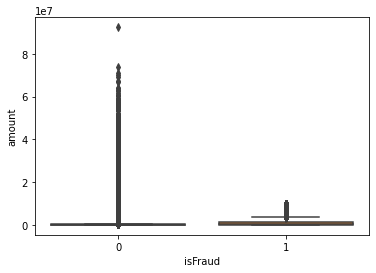

In [6]:
sns.boxplot(x = dados['isFraud'], y = dados['amount'])

<AxesSubplot:xlabel='type', ylabel='amount'>

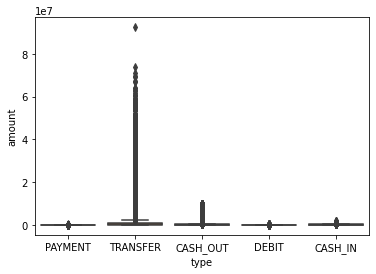

In [7]:
sns.boxplot(x = dados['type'], y = dados['amount'])

Vamos analisar exclusivamente as fraudes e tentar encontrar um padrão

In [8]:
dados_fraude = dados.loc[dados['isFraud'] == 1]

<AxesSubplot:xlabel='type', ylabel='amount'>

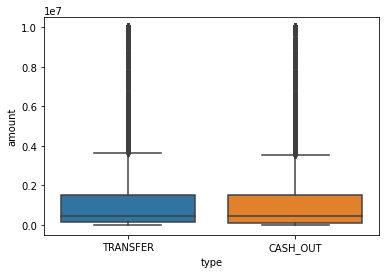

In [9]:
sns.boxplot(x = dados_fraude['type'], y = dados_fraude['amount'])

Só há fraudes nos tipos de transação transfer e cashout

In [10]:
dados_fraude.oldbalanceOrg.mean()

1649667.6057116783

In [11]:
dados_fraude.oldbalanceDest.mean()

544249.6190746377

<AxesSubplot:>

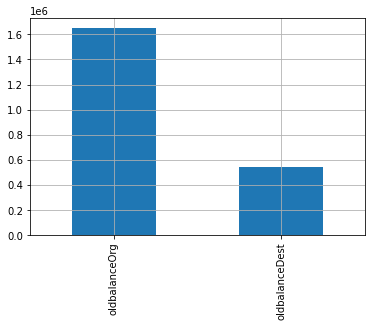

In [12]:
dados_fraude[['oldbalanceOrg','oldbalanceDest']].mean().plot(kind='bar',grid=True)

O saldo médio das contas de origem antes das operações fraudulentas era muito superior aos da de origem.

In [13]:
dados_fraude.newbalanceOrig.mean()

192392.63183611343

In [14]:
dados_fraude.newbalanceDest.mean()

1279707.6171459865

<AxesSubplot:>

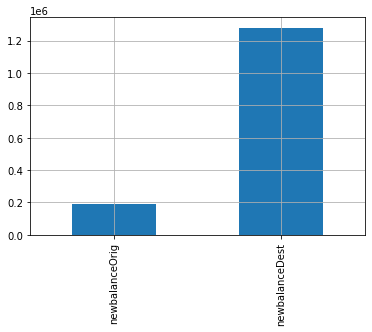

In [15]:
dados_fraude[['newbalanceOrig','newbalanceDest']].mean().plot(kind='bar',grid=True)

O saldo médio da coluna de origem caiu de 1,6 Mi para 192 mil. Já o do destino subiu de 544 mil para 1,27 Mi. Com esses gráficos fica clara a transferência de valores entre o destinatário e receptor das operações fraudulentas. Portanto, é importante que possamos criar features no nosso modelo que ajudem a captar esse movimento. Para ajudar os argumentos da nossa hipótese vamos verificar esse comportamento no dataset completo.

<AxesSubplot:>

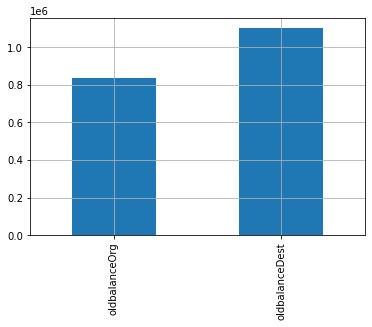

In [16]:
dados[['oldbalanceOrg','oldbalanceDest']].mean().plot(kind='bar',grid=True)

<AxesSubplot:>

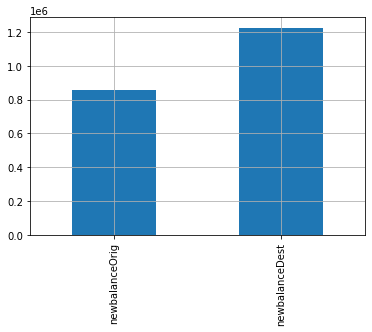

In [17]:
dados[['newbalanceOrig','newbalanceDest']].mean().plot(kind='bar',grid=True)

Quando olhamos nossa população completa a variação entre os valores antes e depois da operação é muito mais sutil. Então aparentemente temos a nossa primeira grande evidência de uma operação fraudulenta, e se criarmos as features corretas nosso modelo será capaz de identificar operações com esse comportamento e taxa-las de fraudulenta.

<AxesSubplot:>

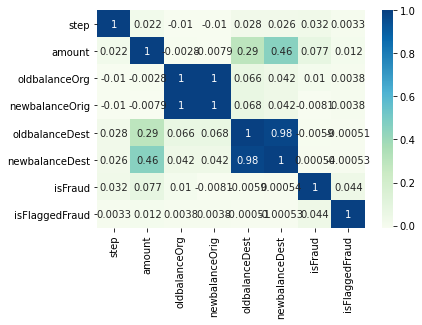

In [18]:
sns.heatmap(dados.corr(),annot=True,cmap='GnBu')

Na correlação podemos ver que a variável que mais se relaciona com a nossa alvo é a amount, porém como vimos a distribuição da amount em relação a nossa variável alvo não é uniforme.

### 3) Feature Engineering

A coluna step representa as horas de 1 a 744, portanto, 31 dias. Assim podemos criar uma coluna com o dia que pode nos ajudar futuramente nos agrupamentos do nosso processo de feature engineering. Nesse caso vamos fazer no pandas por enquanto já que o cudf 0.16, utilizado para a construção desse notebook, ainda não tinha o método apply, com  o qual podemos fazer facilmente essa atribuição no pandas.

In [19]:
hora_i = 1
hora_f = 24
lista_dias = []
lista_horas = []
dia = 1
while dia <= 31:
    for h in range (hora_i-1,hora_f):
        lista_horas.append(h+1)
        lista_dias.append(dia)
    dia += 1
    hora_i += 24
    hora_f += 24  
dic_step = dict(zip(lista_horas,lista_dias))
dados['dia'] = dados.step.map(dic_step)

Vamos aplicar o label encoder nas nossas variáveis categóricas

In [20]:
le = LabelEncoder()

In [21]:
dados['type'] = le.fit_transform(dados['type'])
dados['nameOrig'] = le.fit_transform(dados['nameOrig'])
dados['nameDest'] = le.fit_transform(dados['nameDest'])

Agora vamos dividir nossos dados em treino e teste.

In [22]:
X = dados.drop(columns = 'isFraud')
y = dados.isFraud

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state = 42)

Para adicionar complexidade ao nosso modelo, vamos criar novas features. Começando pelas combinações das variáveis categóricas, nas quais aplicaremos também o label encoder para cada combinação.

In [24]:
def label_encoder(df1,df2,col,verbose=True):
    df_comb = pd.concat([df1[col],df2[col]],axis=0)
    df_comb,_ = df_comb.factorize()
    df1[col] = df_comb[:len(df1)].astype('int32')
    df2[col] = df_comb[len(df1):].astype('int32')
    if verbose: print(col,', ',end='')

def combina_features(df1,df2,col1,col2,verbose=True):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    label_encoder(df1,df2,nm,verbose=False)
    if verbose: print(nm,', ',end='')

In [25]:
combina_features(X_train,X_test,'type','nameOrig')
combina_features(X_train,X_test,'type','nameDest')
combina_features(X_train,X_test,'nameOrig','nameDest')

type_nameOrig , type_nameDest , nameOrig_nameDest , 

In [26]:
X_train.shape,X_test.shape

((4453834, 14), (1908786, 14))

Outras features que podemos acrescentar são as médias dos valores para cada uma das variáveis categóricas, assim é possível que o modelo identifique outliers em casos de fraude

In [27]:
datasets = [X_train,X_test]
for dataset in datasets:
    dataset['type_avg_amount'] = dataset.groupby('type').amount.transform(lambda x: x.mean())
    dataset['orig_avg_amount'] = dataset.groupby('nameOrig').amount.transform('mean')
    dataset['dest_avg_amount'] = dataset.groupby('nameDest').amount.transform('mean')
    dataset['type_avg_oldbalanceDest'] = dataset.groupby('type').oldbalanceDest.transform(lambda x: x.mean())
    dataset['orig_avg_oldbalanceDest'] = dataset.groupby('nameOrig').oldbalanceDest.transform('mean')
    dataset['dest_avg_oldbalanceDest'] = dataset.groupby('nameDest').oldbalanceDest.transform('mean')
    dataset['type_avg_newbalanceDestt'] = dataset.groupby('type').newbalanceDest.transform(lambda x: x.mean())
    dataset['orig_avg_newbalanceDest'] = dataset.groupby('nameOrig').newbalanceDest.transform('mean')
    dataset['dest_avg_newbalanceDest'] = dataset.groupby('nameDest').newbalanceDest.transform('mean')

Também importante é sabermos a quantidade de movimentações feitas no mês para o destinatário e autor da operação, é provável que usuários que façam muitas operações sejam mais propensos a fraudes

In [28]:
for dataset in datasets:
    dataset['orig_count'] = dataset.groupby('nameOrig').amount.transform('count')
    dataset['dest_count'] = dataset.groupby('nameDest').amount.transform('count')

Como fizemos a classificação de dia a partir da coluna step conseguimos também fazer essa contagem por dia. Vamos fazer isso criando uma chave concatenando o  dia e destinatário (e o autor), e então fazendo uma contagem dessa chave.

In [29]:
for dataset in datasets:
    dataset['chave_namedest'] =  dataset.nameDest.astype('str') + '-' + dataset.dia.astype('str')
    dataset['dest_count_dia'] =  dataset.groupby(['chave_namedest','dia']).amount.transform('count')
    dataset['chave_nameOrig'] =  dataset.nameOrig.astype('str') + '-' + dataset.dia.astype('str')
    dataset['orig_count_dia'] =  dataset.groupby(['chave_nameOrig','dia']).amount.transform('count')
    dataset.drop(columns=['chave_nameOrig','chave_namedest'], inplace=True)

In [30]:
X_train

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,...,type_avg_oldbalanceDest,orig_avg_oldbalanceDest,dest_avg_oldbalanceDest,type_avg_newbalanceDestt,orig_avg_newbalanceDest,dest_avg_newbalanceDest,orig_count,dest_count,dest_count_dia,orig_count_dia
2408104,202,0,26771.98,2487575,27521.00,54292.98,18776,7175503.03,7148731.05,0,...,1.587590e+06,7175503.03,6.735236e+06,1.466921e+06,7148731.05,6.987355e+06,1,13,3,1
662430,36,1,344879.65,1909142,0.00,0.00,125492,3731846.57,4076726.22,0,...,1.493955e+06,3731846.57,4.005485e+06,1.687602e+06,4076726.22,4.271616e+06,1,37,10,1
496595,20,4,1862607.84,4401349,0.00,0.00,317835,3329828.01,4913631.27,0,...,2.567985e+06,3329828.01,4.295577e+06,3.553313e+06,4913631.27,4.369077e+06,1,21,9,1
5053741,354,3,37739.35,5203756,66684.93,28945.58,604220,0.00,0.00,0,...,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,1,1,1
755621,38,1,376055.13,2337985,22501.00,0.00,26843,182350.43,558405.55,0,...,1.493955e+06,182350.43,6.151689e+05,1.687602e+06,558405.55,6.435662e+05,1,15,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,155,0,129715.85,2323574,5054252.83,5183968.68,239829,246692.94,116977.09,0,...,1.587590e+06,246692.94,2.301393e+05,1.466921e+06,116977.09,3.190807e+05,1,11,2,1
2234489,186,3,2459.70,2773170,0.00,0.00,1527061,0.00,0.00,0,...,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,1,1,1
4926484,350,1,10579.16,1903639,59279.00,48699.84,35205,322754.16,333333.32,0,...,1.493955e+06,322754.16,3.430566e+05,1.687602e+06,333333.32,2.980068e+05,1,3,2,1
4304572,307,1,73020.76,4311664,20289.00,0.00,284813,256102.84,329123.61,0,...,1.493955e+06,256102.84,2.093845e+05,1.687602e+06,329123.61,2.550009e+05,1,8,2,1


Agora podemos fazer uma feature com a razão do número de transferências no dia em relação ao número de transferências total, dessa forma será possível verificar se em algum dia específico o usuário tem uma movimentação atípica em termos de frequência. 

In [31]:
for dataset in datasets:
    dataset['proporcao_orig_hojevsmes'] = dataset['orig_count_dia']/dataset['orig_count']
    dataset['proporcao_dest_hojevsmes'] = dataset['dest_count_dia']/dataset['dest_count']

Outra feature de proporção que podemos criar é a proporção do valor da transferência em relação ao saldo das contas do receptor e autor da operação, em operações de fraude para "esvaziar" a conta a tendência é que tentem retirar uma grande parte, ou todo, o saldo total.

In [32]:
for dataset in datasets:
    dataset['amountvssaldoorigem'] = dataset['amount']/dataset['oldbalanceOrg']
    dataset['amountvssaldoorigem'].replace(np.inf, 0, inplace=True)
    dataset['amountvssaldoorigem'].replace(np.nan, 0, inplace=True)
    dataset['amountvssaldodest'] = dataset['amount']/dataset['newbalanceDest']
    dataset['amountvssaldodest'].replace(np.nan, 0, inplace=True)
    dataset['amountvssaldodest'].replace(np.inf, 0, inplace=True)

In [33]:
X_train.shape,X_test.shape

((4453834, 31), (1908786, 31))

Portanto, conseguimos chegar a 31 features nos nossos datasets após nosso processo de feature engineering.

### 4) Balanceando o dataset de treino

Agora vamos balancear o nosso dataset de treino que contém poucos dados de fraude. Assim nosso modelo será capaz de captar com mais eficiência as fraudes e evitaremos falsos negativos. Vamos usar a abordagem SMOTE para realizar esse balanceamento.

In [34]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)
smote_value_counts = y_train_smote.value_counts()
print("Operações fraudulentas agora são %.2f%% do dataset de treino." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Operações fraudulentas agora são 50.00% do dataset de treino.


### 5)Treinando os modelos

#### 5.1 Regressão Logística

In [35]:
logreg = LogisticRegression()

In [36]:
logreg.fit(X_train_smote,y_train_smote)

In [56]:
y_pred_logreg = logreg.predict(X_test)

Resultados da Regressão Logística 
A acurácia é:  0.9634684034773935
A precisão do modelo é: 0.030698206365589
O recall é: 0.9039014373716633
F1 Score é: 0.05937976339821672


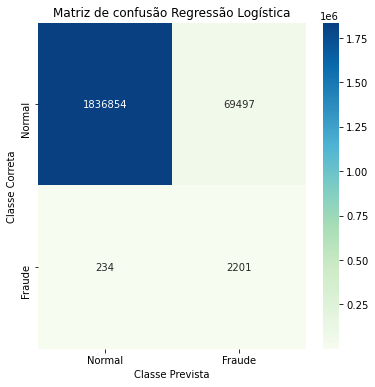

Regressão Logística: 69731 erros
0.9634684034773935
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906351
           1       0.03      0.90      0.06      2435

    accuracy                           0.96   1908786
   macro avg       0.52      0.93      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786



<Figure size 720x432 with 0 Axes>

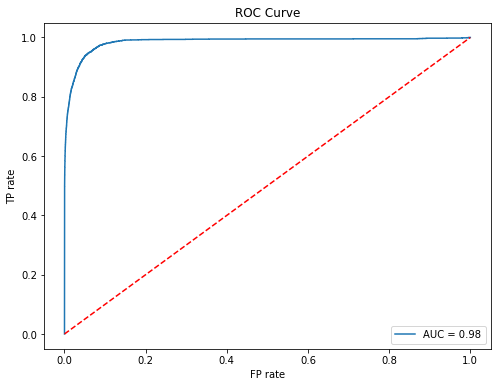

In [57]:
erros = (y_pred_logreg != y_test).sum()
print("Resultados da Regressão Logística ")
acc= accuracy_score(y_test,y_pred_logreg)
print("A acurácia é:  {}".format(acc))
prec= precision_score(y_test,y_pred_logreg)
print("A precisão do modelo é: {}".format(prec))
rec= recall_score(y_test,y_pred_logreg)
print("O recall é: {}".format(rec))
f1= f1_score(y_test,y_pred_logreg)
print("F1 Score é: {}".format(f1))

#matriz de confusão
LABELS = ['Normal', 'Fraude']
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão Regressão Logística")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

# Métricas
plt.figure(figsize=(10,6))
print('{}: {} erros'.format("Regressão Logística", erros))
print(accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

#Curva ROC
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

O nosso modelo de regressão logística gerou resultados interessantes. Tivemos uma acurácia relativamente boa, de 96.3%. Então o modelo foi capaz de prever relativamente bem as fraudes. Ainda assim entre as 2435 fraudes o modelo deixou de identificar 234, o que no mundo real das operações financeiras pode representar um prejuízo considerável. Já a precisão do modelo foi de apenas 3%, isso ocorreu por conta dos 64947 falsos positivos que o modelo identificou como fraude quando na verdade eram operações normais. Para operações bancárias é melhor errar para o esse lado do falso positivo do que deixar passar fraudes que não são fraudes, já que uma identificação de fraude pode ser resolvida facilmente pelo cliente em caso de uma operação normal enquanto uma fraude que não foi identificada pode representar um prejuízo considerável.

#### 5.2) Random Forest Classifier

Agora vamos treinar um modelo de random forest classifier, que faz uso de árvores de decisão para classificação binária. Esse modelo deve desempenhar melhor do que a regressão logística dada a complexidade que conseguimos acrescentar ao nosso dataset com o feature engineering.

In [40]:

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

In [54]:
y_pred_rfc = rfc.predict(X_test)

Avaliando o modelo:

Resultados do modelo Random Forest Classifier 
A acurácia é:  0.9999874265632711
A precisão do modelo é: 0.9983464241422075
O recall é: 0.9917864476386037
F1 Score é: 0.9936358037363991


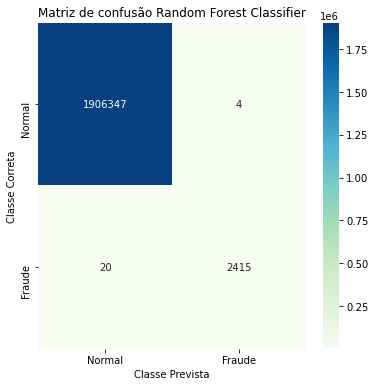

Random Forest: 24 erros
0.9999874265632711
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      0.99      1.00      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 720x432 with 0 Axes>

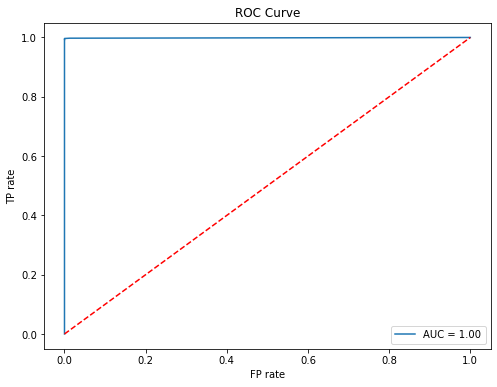

In [55]:
erros = (y_pred_rfc != y_test).sum()
print("Resultados do modelo Random Forest Classifier ")
acc= accuracy_score(y_test,y_pred_rfc)
print("A acurácia é:  {}".format(acc))
prec= precision_score(y_test,y_pred_rfc)
print("A precisão do modelo é: {}".format(prec))
rec= recall_score(y_test,y_pred_rfc)
print("O recall é: {}".format(rec))
f1= f1_score(y_test,y_pred)
print("F1 Score é: {}".format(f1))

#matriz de confusão
LABELS = ['Normal', 'Fraude']
conf_matrix = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão Random Forest Classifier")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

# Métricas
plt.figure(figsize=(10,6))
print('{}: {} erros'.format("Random Forest", erros))
print(accuracy_score(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc))

#Curva ROC
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

Portanto, nosso modelo de Random Forest Classifier foi capaz de prever os dados de teste com 99,9% de precisão. Foram apenas 20 fraudes entre as 2435 que o nosso modelo  não foi capaz de identificar, e entre as não-fraudes foram apenas 4 classificadas como fraudes e 1906347 corretamente como não fraudes.

In [42]:
#from sklearn.inspection import permutation_importance

#importancia = permutation_importance(rfc, X_test, y_test, scoring ='neg_mean_squared_error')
#importancia = importancia.importances_mean
#importancia_lista = []
#for indice, valor in enumerate(importancia):
#    importancia_lista.append([indice,valor])
#    print('Feature: %0d, Score: %.5f' % (indice,valor))

#### 5.3) XGBoost

Agora vamos rodar nosso último modelo, o XGBoost. Vamos primeiramente criar uma função de grid search para localizar os melhores parâmetros do nosso modelo XGBoost. Pra acharmos esses parâmetros vamos utilizar a métrica de AUC (area under curve) e tentar maximiza-la.

In [46]:
def busca_parametros(X, y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Melhor estimador: ")
    print(grid_search.best_estimator_)
    print("Melhores Parâmetros: ", grid_search.best_params_)
    print("AUC mais alto: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

Como nosso dataset de treino é muito grande vamos limitar nosso grid search a 5000 entradas de forma a otimizar o processamento.

In [48]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
parametros = busca_parametros(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Melhor estimador: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 100, 'subsample': 1.0}
AUC mais alto: 1.00


Agora com nossos parâmetros otimizados vamos treinar o modelo e realizar as previsões.

In [49]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**parametros)
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='approx',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [59]:
y_pred_xgb = model.predict(X_test)

Avaliando os resultados:

Resultados do modelo XGBoost 
A acurácia é:  0.9999837593108919
A precisão do modelo é: 0.993431855500821
O recall é: 0.9938398357289527
F1 Score é: 0.9936358037363991


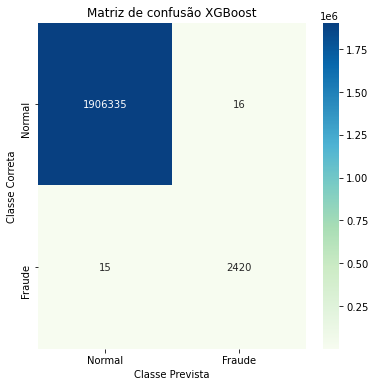

XGBoost: 31 erros
0.9999837593108919
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.99      0.99      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 720x432 with 0 Axes>

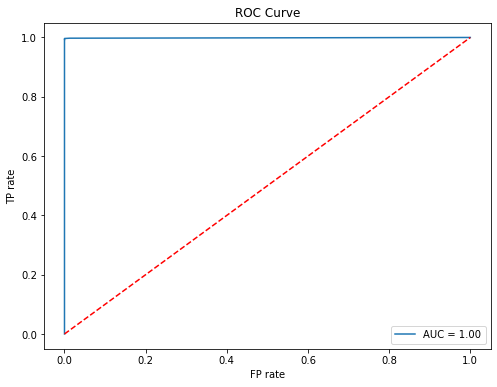

In [60]:
n_errors = (y_pred_xgb != y_test).sum()
print("Resultados do modelo XGBoost ")
acc= accuracy_score(y_test,y_pred_xgb)
print("A acurácia é:  {}".format(acc))
prec= precision_score(y_test,y_pred_xgb)
print("A precisão do modelo é: {}".format(prec))
rec= recall_score(y_test,y_pred_xgb)
print("O recall é: {}".format(rec))
f1= f1_score(y_test,y_pred_xgb)
print("F1 Score é: {}".format(f1))

#matriz de confusão
LABELS = ['Normal', 'Fraude']
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão XGBoost")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

# Métricas
plt.figure(figsize=(10,6))
print('{}: {} erros'.format("XGBoost", n_errors))
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

#Curva ROC
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

Os resultados foram muito próximos do nosso modelo random forest ! Foram apenas 15 fraudes entre as 2435 que o nosso modelo  não foi capaz de identificar, e entre as não-fraudes foram apenas 16 classificadas como fraudes e 1906347 corretamente como não fraudes. Em relação ao random forest tivemos 5 fraudes não identificadas a menos, porém tivemos 12 não fraudes a mais identificadas como fraudes (O que não chega a ser um problema, dado que no problema de identificação de fraudes é sempre melhor errar para o lado de identificar a fraude quando não há do que deixar de identifica-la quando ela realmente ocorre, o que no nosso modelo XGBoost foi otimizado)

### 6) Conclusão

Conseguimos criar três modelos para previsão de fraudes e os dois modelos robustos, Random Forest e XGBoost, foram extremamente eficientes na identificação de fraudes com precisões e recalls superiores a 99%. Como sugestão de melhoria desse trabalho temos a adaptação do código para fazer uso do processamento GPU pelo módulo Rapids da NVIDIA e utilizar os módulos cudf para realizar o processo de feature engineering e cuml para treinamento dos modelos em processamento paralelo para uma performance superior em termos de processamento.